In [1]:
import os
import pickle

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
import numpy as np
import pandas as pd
from scipy import stats
from tqdm import tqdm

from lib.data import conditions as cond
from lib.data import tables as tab
from lib.features import decomposition as de
from lib.features import correlation as corr

In [2]:
np.random.seed(42)
plt.rc('svg', fonttype='none')

# Load data

In [3]:
engine = tab.sa.create_engine(os.environ['SQLALCHEMY_ENGINE_URL'])
Session = tab.sa.orm.sessionmaker(bind=engine)
session = Session()

Get the IDs of all cells that were added to the dataset on the first day.

In [4]:
day_one_cells = (
    session.query(tab.Cell)
    .join(tab.Cell.traces, tab.Trial)
    .filter(tab.Trial.day == 1)
    .subquery()
)

Get the average traces for non-catch trials of `day_one_cells` on days 1 and 7.

In [5]:
average_traces = []
days = []
cell_types = []
cell_ids = []
mouse_ids = []

for res in tqdm(
    session.query(tab.TrialAverageTrace, tab.Mouse)
        .join(day_one_cells, tab.TrialAverageTrace.cell_id==day_one_cells.c.id)
        .join(tab.Mouse, day_one_cells.c.mouse_id==tab.Mouse.id)
        .filter(
            tab.TrialAverageTrace.day.in_([1, 7]), 
            tab.TrialAverageTrace.trial_kind == 'non_catch',
            tab.Mouse.cell_type != cond.CellType.som,  # Excluded b/c few neurons
            tab.Mouse.id != 'CL199',  # Excluded b/c fluorescence drift
        )
        .all()
):
    if not all(np.isnan(res[0].trace)):
        average_traces.append(res[0].trace)
        days.append(res[0].day)
        cell_ids.append(res[0].cell_id)
        cell_types.append(res[1].cell_type)
        mouse_ids.append(res[1].id)

100%|██████████| 3864/3864 [00:00<00:00, 165510.53it/s]


In [6]:
average_traces = np.array([tr[:390] for tr in average_traces])
days = np.array(days)
cell_types = np.array(cell_types)
cell_ids = np.array(cell_ids)

In [7]:
average_traces.shape

(3851, 390)

In [8]:
days

array([1, 7, 1, ..., 7, 1, 7])

In [9]:
cell_types

array([CellType.vip, CellType.vip, CellType.vip, ..., CellType.pv,
       CellType.pv, CellType.pv], dtype=object)

In [10]:
np.sum((days == 1) & (cell_types == cond.CellType.vip))

407

The data I imported has 407 VIP cells on day 1. If I did everything right, that should match your analysis.

# Helper function for saving figures

In [11]:
def savefig(fig_basename, **kwargs):
    for extension in ['png', 'svg']:
        print(f'Saving {extension}')
        plt.savefig('.'.join([fig_basename, extension]), **kwargs)

**Trial components**

Durations are in seconds.

In [12]:
trial_structure = de.TrialBasisFunctions(
    390, tone_duration=1.0, delay_duration=1.5, reward_duration=2.5
)

Trial structure is represented in terms of a set of rectangular functions. Here's one of them.

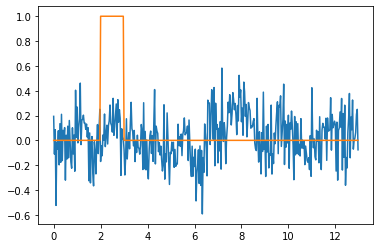

In [13]:
plt.plot(trial_structure.time, average_traces[10, :])
plt.plot(trial_structure.time, trial_structure.tone)

Which components are needed to capture trial structure? To find out, compute the cos similarity between a one-hot vector for each part of the trial and each component.

In [14]:
mean_fluorescence = {
    'tone': corr.vectorized_spearman_corr(average_traces, trial_structure.tone),
    'tone + delay': corr.vectorized_spearman_corr(average_traces, trial_structure.tone + trial_structure.delay),
    'reward': corr.vectorized_spearman_corr(average_traces, trial_structure.reward),
}

In [15]:
mean_fluo_df = pd.DataFrame(
    {
        'day': days,
        'cell_type': cell_types,
        'cell_id': cell_ids,
        'mouse_id': mouse_ids,
        **mean_fluorescence
    }
)
mean_fluo_df

,day,cell_type,cell_id,mouse_id,tone,tone + delay,reward
0,1,vip,3121,CL136,-0.042650,-0.089601,-0.110405
1,7,vip,3121,CL136,-0.205642,-0.022913,-0.320235
2,1,vip,3122,CL136,0.110171,0.048225,-0.311567
3,7,vip,3122,CL136,-0.240343,-0.429629,-0.054292
4,1,vip,3123,CL136,-0.062735,-0.045220,-0.022335
...,...,...,...,...,...,...,...
3846,7,pv,2644,CL198,-0.157180,-0.062845,0.159005
3847,1,pv,2645,CL198,-0.063077,0.110058,-0.012685
3848,7,pv,2645,CL198,-0.254787,-0.206854,0.091508
3849,1,pv,2646,CL198,-0.070769,0.044699,0.033546


In [16]:
mean_fluo_df.describe()

,day,cell_id,tone,tone + delay,reward
count,3851.000000,3851.000000,3851.000000,3851.000000,3851.000000
mean,3.999221,1750.525837,-0.039512,-0.013280,-0.011403
std,3.000389,1065.270517,0.191138,0.225682,0.246005
min,1.000000,1.000000,-0.460685,-0.672803,-0.676155
25%,1.000000,959.000000,-0.169189,-0.148719,-0.161663
50%,1.000000,1722.000000,-0.062564,-0.019157,-0.011876
75%,7.000000,2784.500000,0.070769,0.105204,0.128984
max,7.000000,3526.000000,0.461369,0.663499,0.682511


In [17]:
mean_fluo_df.to_csv('../../interneuron-reward-data/processed/mean_fluo_df.csv', index=False)

In [18]:
def mark_trial_structure():
    plt.axvspan(
        min(trial_structure.time[trial_structure.tone]) - trial_structure.baseline_duration,
        max(trial_structure.time[trial_structure.tone]) - trial_structure.baseline_duration,
        color='gray',
        label='Tone'
    )
    plt.axvline(
        min(trial_structure.time[trial_structure.reward]) - trial_structure.baseline_duration,
        color='gray',
        ls='--',
        label='Reward delivery',
    )

In [19]:
def to_unit_interval(x):
    return (x + 1) * 0.5

Cell types to show for tone + delay:      cell_type  tone + delay
1388       pyr     -0.341501
1442       pyr      0.636107
1590       pyr      0.310411
2026       pyr     -0.667255
2940       pyr     -0.015574
Cell types to show for reward:      cell_type    reward
856         pv  0.004479
1638       pyr  0.344160
2072       pyr  0.682511
2160       pyr -0.672514
2224       pyr -0.333064
Saving png


<ipython-input-20-939e87b0b78e>:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saving svg


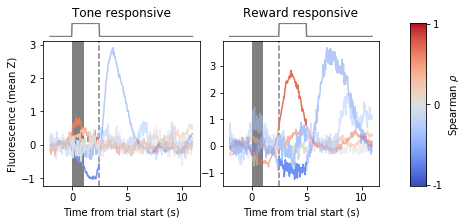

In [20]:
plt.figure(figsize=(7, 3))

spec = gs.GridSpec(
    2, 3, width_ratios=[1, 1, 0.2], height_ratios=[0.1, 1], hspace=0.05
)

for i, (trial_component, label, mask) in enumerate(
    zip(
        ['tone + delay', 'reward'], 
        ['Tone responsive', 'Reward responsive'],
        [trial_structure.tone + trial_structure.delay, trial_structure.reward]
    )
):

    # Find the inds of cells with various values of mean fluorescence
    all_cell_fluo_means = mean_fluo_df.loc[mean_fluo_df['day'] == cond.Day(7), trial_component].to_numpy()
    cells_to_show = np.unique(
        np.argmin(
            np.abs(
                all_cell_fluo_means 
                - np.linspace(
                    all_cell_fluo_means.min(), all_cell_fluo_means.max(), 5
                )[:, np.newaxis]
            ),
            1
        )
    )
    print(f'Cell types to show for {trial_component}: {mean_fluo_df.loc[mean_fluo_df["day"] == cond.Day(7), ["cell_type", trial_component]].iloc[cells_to_show, :]}')

    traces_ = average_traces[days == cond.Day(7), :][cells_to_show, :].T
    means_ = mean_fluo_df.loc[mean_fluo_df['day'] == cond.Day(7), trial_component].iloc[cells_to_show]


    plt.subplot(spec[0, i])
    plt.title(label)
    plt.plot(
        trial_structure.time - trial_structure.baseline_duration,
        mask,
        color='gray',
    )
    plt.gca().axis('off')
    
    plt.subplot(spec[1, i])
    mark_trial_structure()
    
    for j in range(len(means_)):
        component = traces_[:, j].copy()
        component[~mask] = np.nan
        
        plt.plot(
            trial_structure.time - trial_structure.baseline_duration,
            component,
            color=plt.cm.coolwarm(to_unit_interval(means_.iloc[j]))
        )
        
        not_component = traces_[:, j].copy()
        not_component[mask] = np.nan
        
        plt.plot(
            trial_structure.time - trial_structure.baseline_duration,
            not_component,
            color=plt.cm.coolwarm(to_unit_interval(means_.iloc[j])),
            alpha=0.5
        )

    if i == 0:
        plt.ylabel('Fluorescence (mean Z)')
    
    plt.xlabel('Time from trial start (s)')
    
ax = plt.subplot(spec[:, -1])
plt.imshow(np.linspace(1, -1, 101)[:, np.newaxis], cmap='coolwarm', aspect=0.1)
plt.yticks([0, 50, 100], [1, 0, -1])
plt.gca().yaxis.set_ticks_position('right')
plt.gca().yaxis.set_label_position('right')
plt.ylabel('Spearman $\\rho$')
plt.xticks([])

plt.tight_layout()

savefig('../img/graphics/sample_responsive_cells', dpi=600, bbox_inches='tight')

del cells_to_show, traces_, means_

In [21]:
FRAME_RATE = 30.0
BASELINE_DURATION = 2.
time_vec = np.arange(390) / FRAME_RATE - BASELINE_DURATION

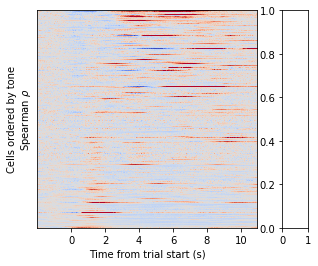

In [23]:
celltype_number = {
    cond.CellType.pyr: 0,
    cond.CellType.vip: 1,
    cond.CellType.pv: 2
}

Saving png
Saving svg


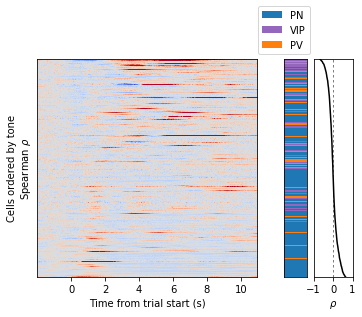

In [24]:
fluo_spec = gs.GridSpec(1, 3, width_ratios=[1, 0.1, 0.15], wspace=0.05)

plt.subplot(fluo_spec[:, 0])
plt.imshow(
    average_traces[
        days == cond.Day(7), 
        :
    ][
        np.argsort(mean_fluo_df.loc[mean_fluo_df['day'] == cond.Day(7), 'tone + delay']),
        :
    ],
    cmap='coolwarm',
    vmin=-2,
    vmax=2,
    aspect=0.2
)
plt.xticks((np.arange(0, 11, 2) + BASELINE_DURATION) * FRAME_RATE, np.arange(0, 11, 2))
plt.yticks([])
plt.ylabel('Cells ordered by tone\nSpearman $\\rho$')
plt.xlabel('Time from trial start (s)')

ax = plt.subplot(fluo_spec[:, 1])
ct_barcode = ax.imshow(
    np.array([celltype_number[ct] 
              for ct in 
              cell_types[days==7][np.argsort(mean_fluo_df.loc[mean_fluo_df['day'] == cond.Day(7), 'tone + delay'])]]
            )[:, np.newaxis], 
    aspect=0.005,
    cmap=ListedColormap([sns.color_palette()[i] for i in [0, 4, 1]])
)
ax.set_yticks([])
ax.set_xticks([])
ax.legend(handles=[
    Patch(facecolor=sns.color_palette()[0], label='PN'), 
    Patch(facecolor=sns.color_palette()[4], label='VIP'), 
    Patch(facecolor=sns.color_palette()[1], label='PV'), 
], loc='lower center', bbox_to_anchor=(0, 1))

plt.subplot(fluo_spec[:, 2])
plt.axvline(0, color='k', ls='--', lw=0.5, dashes=(5, 5))
plt.plot(
    np.sort(mean_fluo_df.loc[mean_fluo_df['day'] == cond.Day(7), 'tone + delay']),
    np.linspace(1, 0, sum(mean_fluo_df['day'] == cond.Day(7))),
    'k-'
)
plt.ylim(0, 1)
plt.xlim(-1, 1)
plt.yticks([])
plt.xlabel('$\\rho$')

savefig('../img/graphics/fluo_ordered_by_tone', dpi=600, bbox_inches='tight')
plt.show()

In [25]:
stats.ks_2samp(
    mean_fluo_df.loc[mean_fluo_df['day'] == cond.Day(1), 'tone + delay'].to_numpy().flatten(),
    mean_fluo_df.loc[mean_fluo_df['day'] == cond.Day(7), 'tone + delay'].to_numpy().flatten()
)

Ks_2sampResult(statistic=0.04853663470485901, pvalue=0.020542850706364413)

Saving png
Saving svg


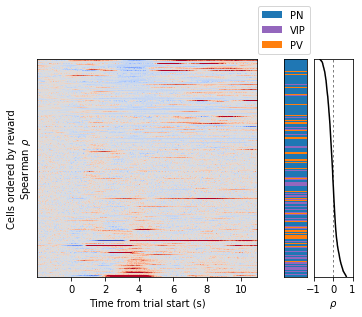

In [26]:
plt.subplot(fluo_spec[:, 0])
plt.imshow(
    average_traces[
        days == cond.Day(7), 
        :
    ][
        np.argsort(mean_fluo_df.loc[mean_fluo_df['day'] == cond.Day(7), 'reward']),
        :
    ],
    cmap='coolwarm',
    vmin=-2,
    vmax=2,
    aspect=0.2
)
plt.xticks((np.arange(0, 11, 2) + BASELINE_DURATION) * FRAME_RATE, np.arange(0, 11, 2))
plt.yticks([])
plt.ylabel('Cells ordered by reward\nSpearman $\\rho$')
plt.xlabel('Time from trial start (s)')

ax = plt.subplot(fluo_spec[:, 1])
ct_barcode = ax.imshow(
    np.array([celltype_number[ct] 
              for ct in 
              cell_types[days==7][np.argsort(mean_fluo_df.loc[mean_fluo_df['day'] == cond.Day(7), 'reward'])]]
            )[:, np.newaxis], 
    aspect=0.005,
    cmap=ListedColormap([sns.color_palette()[i] for i in [0, 4, 1]])
)
ax.set_yticks([])
ax.set_xticks([])
ax.legend(handles=[
    Patch(facecolor=sns.color_palette()[0], label='PN'), 
    Patch(facecolor=sns.color_palette()[4], label='VIP'), 
    Patch(facecolor=sns.color_palette()[1], label='PV'), 
], loc='lower center', bbox_to_anchor=(0, 1))

plt.subplot(fluo_spec[:, 2])
plt.axvline(0, color='k', ls='--', lw=0.5, dashes=(5, 5))
plt.plot(
    np.sort(mean_fluo_df.loc[mean_fluo_df['day'] == cond.Day(7), 'reward']),
    np.linspace(1, 0, sum(mean_fluo_df['day'] == cond.Day(7))),
    'k-'
)
plt.ylim(0, 1)
plt.xlim(-1, 1)
plt.yticks([])
plt.xlabel('$\\rho$')

savefig('../img/graphics/fluo_ordered_by_reward', dpi=600, bbox_inches='tight')

plt.show()

In [27]:
stats.ks_2samp(
    mean_fluo_df.loc[mean_fluo_df['day'] == cond.Day(1), 'reward'].to_numpy().flatten(),
    mean_fluo_df.loc[mean_fluo_df['day'] == cond.Day(7), 'reward'].to_numpy().flatten()
)

Ks_2sampResult(statistic=0.12013297190867284, pvalue=1.5393242236427795e-12)